In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.ramsey as ramsey
import standard_sequences.pinopi as pnp

In [2]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"

bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)


In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(IQ_angle=60, RO_LO_34=6.4804, ROIF=0.1026600000000002, ro_freq=6.72736, ge_time=77, qubit_id=q1, mixer_offset_ef=6, mixer_offset_ge=2.5, ro_dur=3000, ge_amp=1, ef_half_amp=1.3, RO_LO=6.6247, ef_amp=1.5, qubit_thr=[-10000, -600], ge_ssm=-0.117, RO_LO_pwr=16, RO_IF=None, RO_LO_45=6.3804, ef_half_time=25, ef_time=44, ef_ssm=-0.25684, ro_amp=0.5)
Qubit(IQ_angle=25, RO_LO_34=6.4804, ROIF=0.030700000000000394, ro_freq=6.6554, ge_time=62, qubit_id=q2, mixer_offset_ef=None, mixer_offset_ge=2.5, ro_dur=3000, ge_amp=1, ef_half_amp=None, RO_LO=6.6247, ef_amp=1, qubit_thr=[-10000, 1900], ge_ssm=-0.155, RO_LO_pwr=16, RO_IF=None, RO_LO_45=6.3804, ef_half_time=None, ef_time=None, ef_ssm=-0.2962, ro_amp=0.7)


In [4]:
def make_hist(IQdata, ax_hist,labelstr):
    binwidth = 200
    lim_IQ_min = np.min([IQdata])
    lim_IQ_max = np.max([IQdata])
    
    bins_IQ = np.arange(lim_IQ_min, lim_IQ_max, binwidth)
    
    counts_IQ = ax_hist.hist(IQdata, bins=bins_IQ, histtype='step', orientation='vertical', label = labelstr)[0]
    
    gauss_xaxis = np.linspace(lim_IQ_min,lim_IQ_max, len(counts_IQ))
    
    
    return bins_IQ,counts_IQ, gauss_xaxis


def plot_hist_and_fit(data_g, data_e, label_g, label_e, axis_label):
    ax = plt.axes()
    print(f"{axis_label} histogram")
    bins_g, counts_g, gauss_x_g = make_hist(data_g, ax, label_g)
    bins_e, counts_e, gauss_x_e = make_hist(data_e, ax, label_e)
    _, mu_g, std_g = analysis.fit_gaussian_no_plot(data_g, gauss_x_g, counts_g, ax)
    _, mu_e, std_e = analysis.fit_gaussian_no_plot(data_e, gauss_x_e, counts_e, ax)
    ax.legend()
    plt.show()
    return mu_g, std_g, mu_e, std_e

In [15]:
def run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps):
    # pnp.pi_nopi_ge(0, 0, q2, q1, general_vals_dict)
    # pnp.pi_nopi_ge(1, 1, q2, q1, general_vals_dict)

    pnp.pi_nopi_ge(0, 0, q1, q2, general_vals_dict)
    pnp.pi_nopi_ge(1, 1, q1, q2, general_vals_dict)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )
    return values

def get_snr(q1, q2, general_vals_dict,num_steps, reps):
    values= run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps) 
    mu_Ig, std_Ig, mu_Ie, std_Ie = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[0, :, 0],  # Ig
        values.rec_readout_vs_pats_1[0, :, 1],  # Ie
        'I2g', 'I2e', 'I'
    )

    # Plot and fit Q quadrature
    mu_Qg, std_Qg, mu_Qe, std_Qe = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[1, :, 0],  # Qg
        values.rec_readout_vs_pats_1[1, :, 1],  # Qe
        'Q2g', 'Q2e', 'Q'
    )

    # Calculate SNR
    signal = np.sqrt((mu_Ig - mu_Ie) ** 2 + (mu_Qg - mu_Qe) ** 2)
    noise = np.mean([np.abs(std_Ig), np.abs(std_Qg), np.abs(std_Ie), np.abs(std_Qe)])
    SNR = signal / noise

    print("SNR:", SNR)
    return SNR

def ramsey_quantum_efficiency(q1, q2, general_vals_dict,num_steps, reps,RO_ram_amp=0.0,buffer = 500 ,):
    
    ramsey.ramsey_quantum_efficiency(q1,q2, general_vals_dict,num_steps,RO_ram_amp, buffer)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )
    
    return values

def sweep_ramsey_quantum_efficiency(RO_ram_amp_start,RO_ram_amp_stop,RO_ram_amp_steps):
    num_steps=51
    reps=2000
    buffer = 200

    RO_ram_amp_list = np.linspace(RO_ram_amp_start,RO_ram_amp_stop,RO_ram_amp_steps)
    ramsey_I = np.zeros((RO_ram_amp_steps, num_steps))
    ramsey_Q = np.zeros((RO_ram_amp_steps, num_steps))

    for i, RO_ram_amp in enumerate(RO_ram_amp_list):
        values= ramsey_quantum_efficiency(q2, q1, general_vals_dict,num_steps, reps,RO_ram_amp,buffer)
        I=values.rec_avg_vs_pats_1[0]
        Q=values.rec_avg_vs_pats_1[1]
        ramsey_Q[i] = Q
        ramsey_I[i] = I
    return ramsey_I, ramsey_Q

def fit_ramsey_amplitude(times, ramsey_I, ramsey_Q, fixed_freq):
    ramsey_amp = np.zeros(ramsey_I.shape[0])

    for i in range(ramsey_I.shape[0]):
        I = ramsey_I[i]
        Q = ramsey_Q[i]
        Qrange = np.ptp(Q)
        Irange = np.ptp(I)
        fit_data = Q if Qrange > Irange else I
        fit_vals, _, _, _ = analysis.fit_sine_fix_freq(
            times, fit_data, guess_vals=[100, -67.76, -3600], fixed_freq=fixed_freq
        )
        ramsey_amp[i] = abs(fit_vals[0])
        print(f'Index {i}: Amp={fit_vals[0]:.5f} ({"Q" if Qrange > Irange else "I"})')
    return ramsey_amp


In [6]:
def sweep_ro_freq(sweep_list):
    num_steps=3
    reps=15000
    SNR_list = []
    for freq in sweep_list:
        q2.ROIF = freq-readout_dict["RO_LO"]
        SNR = get_snr(q2, q1, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

def sweep_ro_amp(sweep_list):
    num_steps=3
    reps=15000
    SNR_list = []
    for amp in sweep_list:
        q2.ro_amp = amp
        SNR = get_snr(q2, q1, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.454944 sec
Captured 34 buffers (2.968151 buffers per sec)
Captured 104448 records (9118.159020 records per sec)
Transferred 1711276032 bytes (149391917.379549 bytes per sec)


<Figure size 800x800 with 0 Axes>

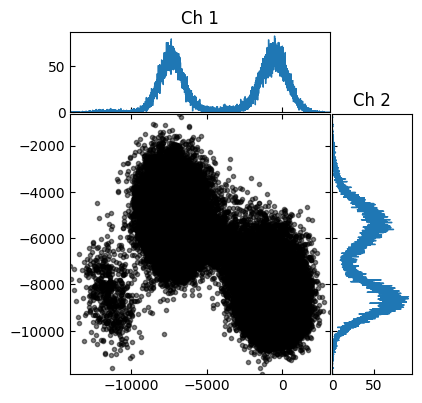

<Figure size 800x800 with 0 Axes>

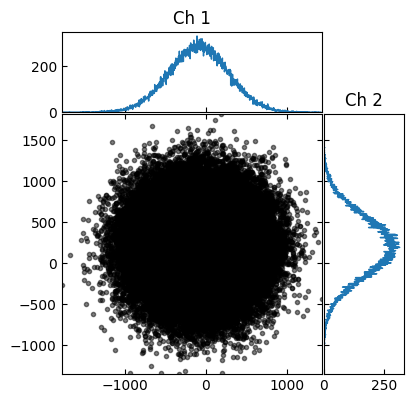

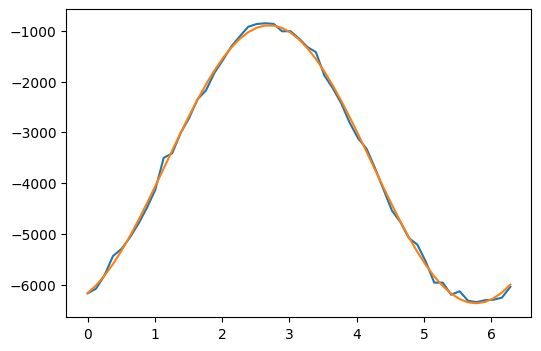



freq: 0.16267379625222506
 amp: -2738.5049528955014
phase: -86.0089950399338
offset: -3630.8448111104044


In [13]:
num_steps=51
reps=2000
RO_ram_amp=0.0
buffer = 200
times = np.linspace(0, 2 * np.pi, num_steps)
values= ramsey_quantum_efficiency(q2, q1, general_vals_dict,num_steps, reps,RO_ram_amp,buffer)
I=values.rec_avg_vs_pats_1[0]
Q=values.rec_avg_vs_pats_1[1]
Qrange = np.ptp(Q)  # peak-to-peak range
Irange = np.ptp(I)
if Qrange > Irange:
    fit_data = Q
else:
    fit_data = I


fit_vals,_,_,_ = analysis.fit_sine(times,fit_data,guess_vals=[.16 ,100,-67.76128980276253,-263.4006117568909])

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.238521 sec
Captured 34 buffers (3.025309 buffers per sec)
Captured 104448 records (9293.749908 records per sec)
Transferred 1711276032 bytes (152268798.493949 bytes per sec)


<Figure size 800x800 with 0 Axes>

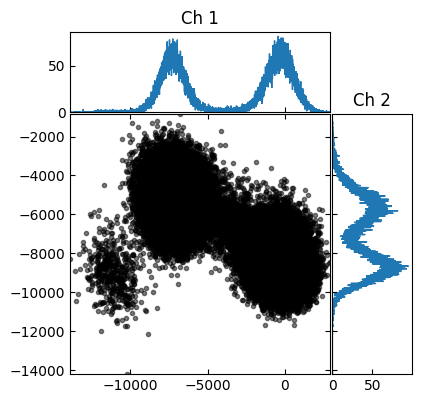

<Figure size 800x800 with 0 Axes>

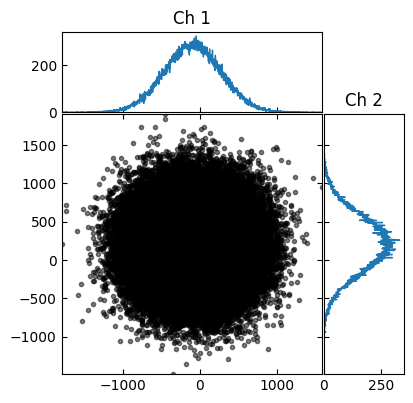

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.257708 sec
Captured 34 buffers (3.020153 buffers per sec)
Captured 104448 records (9277.909795 records per sec)
Transferred 1711276032 bytes (152009274.086221 bytes per sec)


<Figure size 800x800 with 0 Axes>

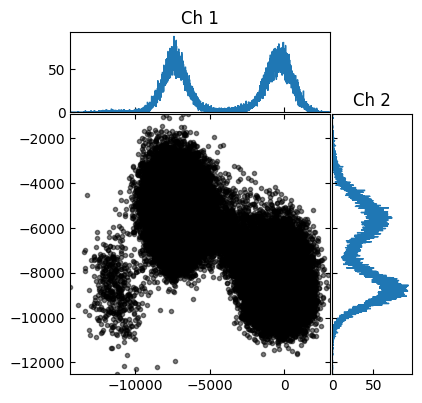

<Figure size 800x800 with 0 Axes>

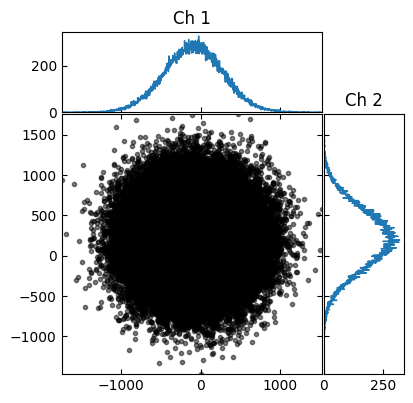

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.119910 sec
Captured 34 buffers (3.057579 buffers per sec)
Captured 104448 records (9392.881977 records per sec)
Transferred 1711276032 bytes (153892978.308359 bytes per sec)


<Figure size 800x800 with 0 Axes>

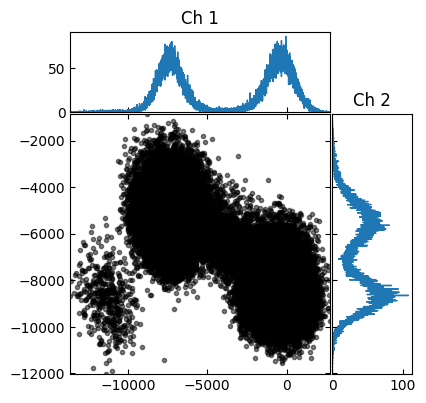

<Figure size 800x800 with 0 Axes>

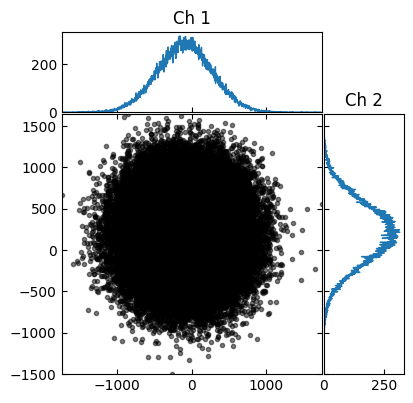

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.032955 sec
Captured 34 buffers (3.081677 buffers per sec)
Captured 104448 records (9466.910987 records per sec)
Transferred 1711276032 bytes (155105869.609930 bytes per sec)


<Figure size 800x800 with 0 Axes>

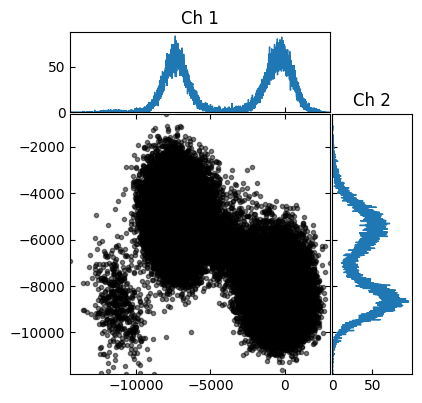

<Figure size 800x800 with 0 Axes>

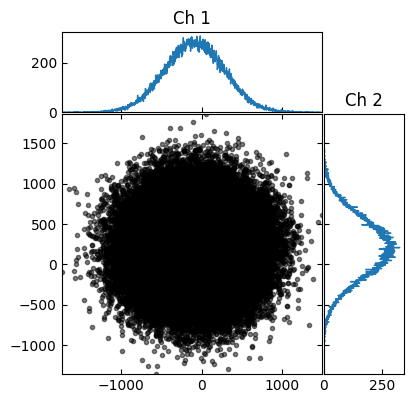

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.016306 sec
Captured 34 buffers (3.086334 buffers per sec)
Captured 104448 records (9481.217770 records per sec)
Transferred 1711276032 bytes (155340271.940289 bytes per sec)


<Figure size 800x800 with 0 Axes>

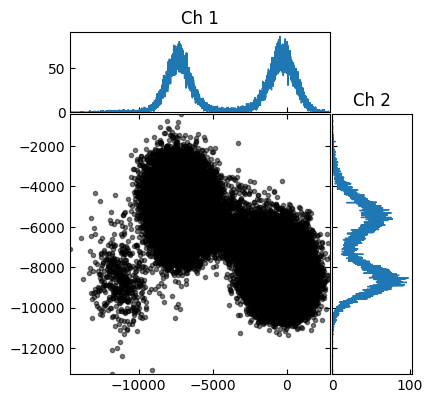

<Figure size 800x800 with 0 Axes>

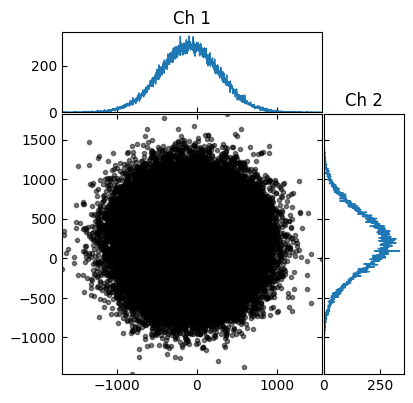

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.533795 sec
Captured 34 buffers (2.947859 buffers per sec)
Captured 104448 records (9055.822758 records per sec)
Transferred 1711276032 bytes (148370600.066296 bytes per sec)


<Figure size 800x800 with 0 Axes>

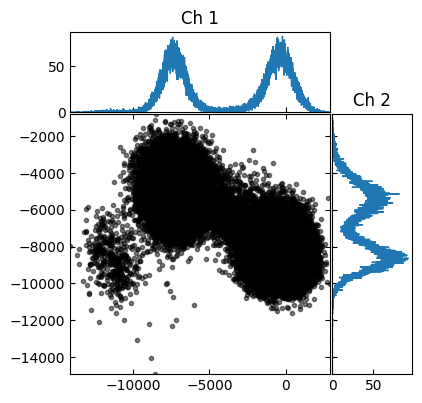

<Figure size 800x800 with 0 Axes>

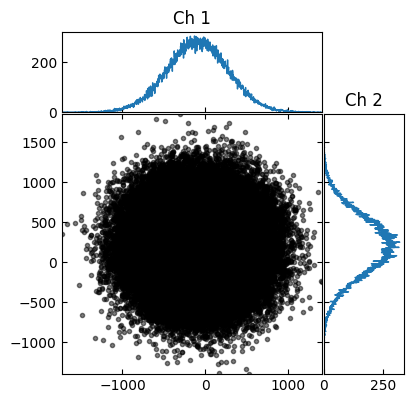

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.102275 sec
Captured 34 buffers (3.062435 buffers per sec)
Captured 104448 records (9407.801441 records per sec)
Transferred 1711276032 bytes (154137418.815444 bytes per sec)


<Figure size 800x800 with 0 Axes>

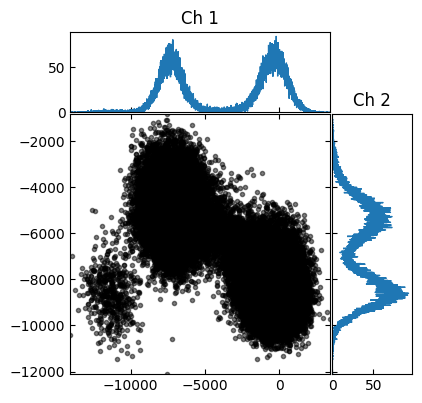

<Figure size 800x800 with 0 Axes>

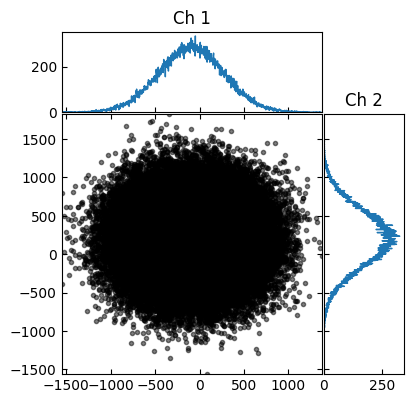

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.621959 sec
Captured 34 buffers (2.925496 buffers per sec)
Captured 104448 records (8987.124986 records per sec)
Transferred 1711276032 bytes (147245055.774218 bytes per sec)


<Figure size 800x800 with 0 Axes>

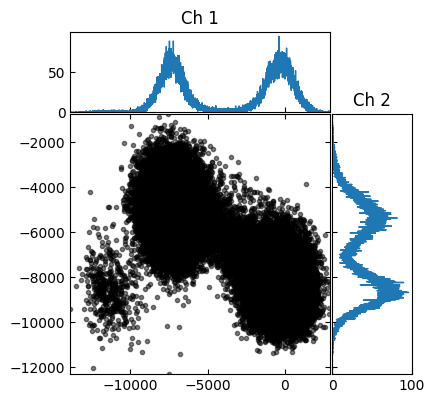

<Figure size 800x800 with 0 Axes>

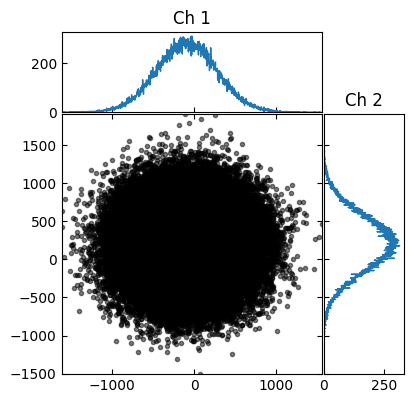

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.225071 sec
Captured 34 buffers (3.028934 buffers per sec)
Captured 104448 records (9304.885109 records per sec)
Transferred 1711276032 bytes (152451237.628209 bytes per sec)


<Figure size 800x800 with 0 Axes>

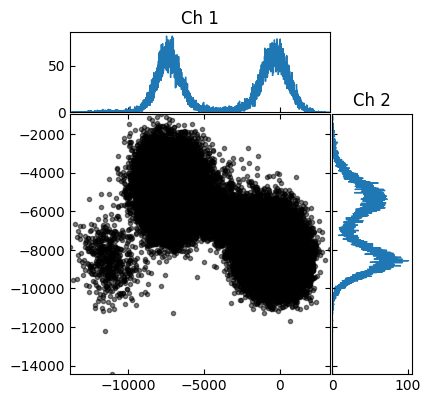

<Figure size 800x800 with 0 Axes>

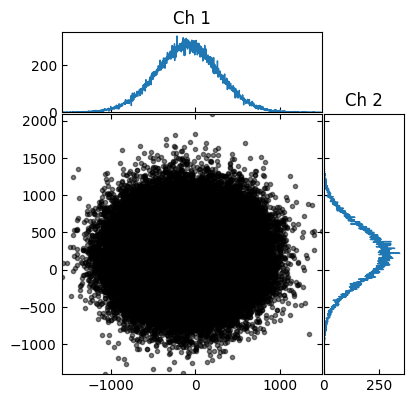

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.316786 sec
Captured 34 buffers (3.004387 buffers per sec)
Captured 104448 records (9229.475730 records per sec)
Transferred 1711276032 bytes (151215730.364735 bytes per sec)


<Figure size 800x800 with 0 Axes>

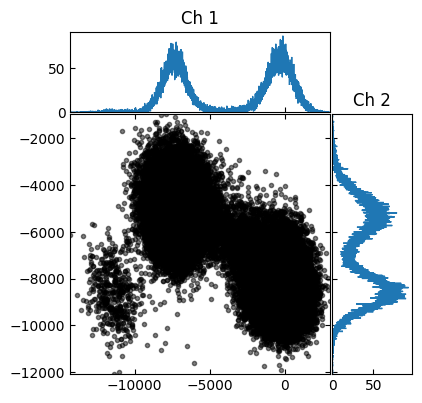

<Figure size 800x800 with 0 Axes>

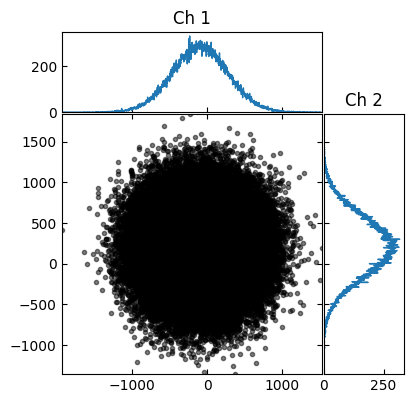

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.311004 sec
Captured 34 buffers (3.005922 buffers per sec)
Captured 104448 records (9234.193207 records per sec)
Transferred 1711276032 bytes (151293021.507593 bytes per sec)


<Figure size 800x800 with 0 Axes>

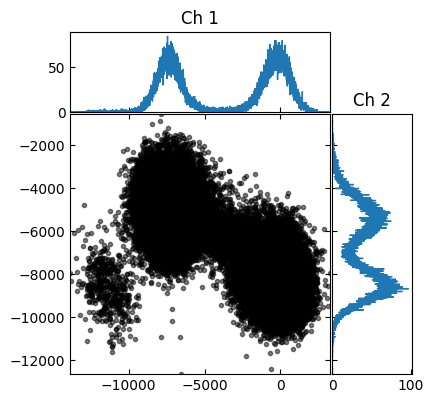

<Figure size 800x800 with 0 Axes>

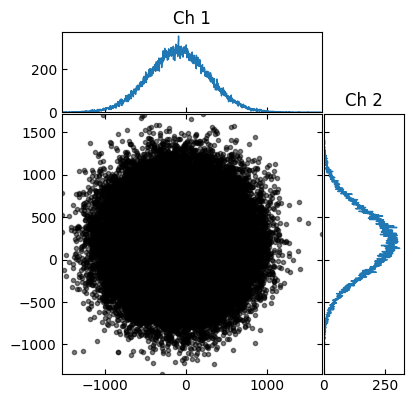

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 12.524784 sec
Captured 34 buffers (2.714618 buffers per sec)
Captured 104448 records (8339.305434 records per sec)
Transferred 1711276032 bytes (136631180.222992 bytes per sec)


<Figure size 800x800 with 0 Axes>

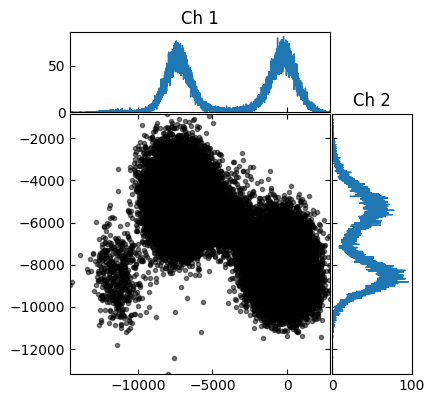

<Figure size 800x800 with 0 Axes>

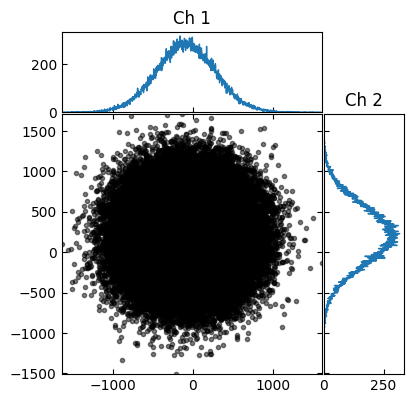

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 12.465995 sec
Captured 34 buffers (2.727420 buffers per sec)
Captured 104448 records (8378.633024 records per sec)
Transferred 1711276032 bytes (137275523.470540 bytes per sec)


<Figure size 800x800 with 0 Axes>

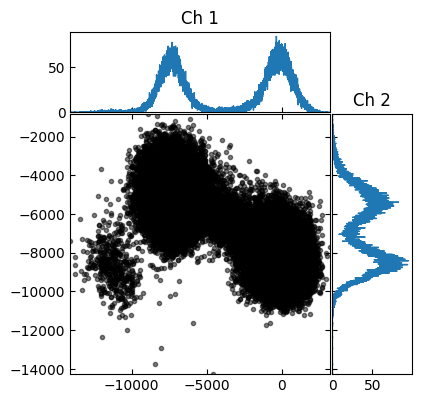

<Figure size 800x800 with 0 Axes>

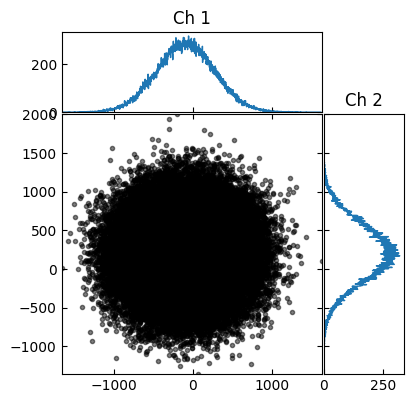

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.746146 sec
Captured 34 buffers (2.894566 buffers per sec)
Captured 104448 records (8892.108128 records per sec)
Transferred 1711276032 bytes (145688299.574433 bytes per sec)


<Figure size 800x800 with 0 Axes>

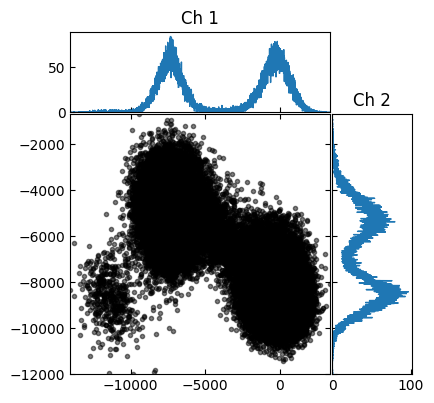

<Figure size 800x800 with 0 Axes>

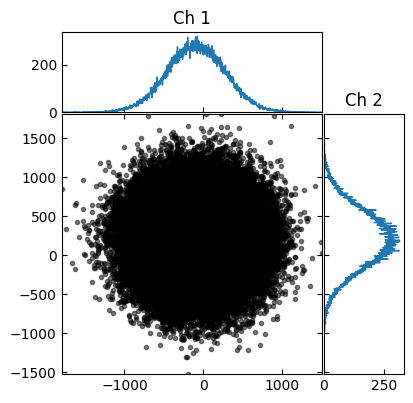

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.980916 sec
Captured 34 buffers (2.837846 buffers per sec)
Captured 104448 records (8717.864293 records per sec)
Transferred 1711276032 bytes (142833488.581215 bytes per sec)


<Figure size 800x800 with 0 Axes>

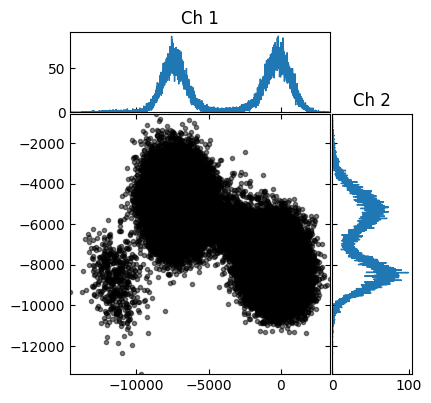

<Figure size 800x800 with 0 Axes>

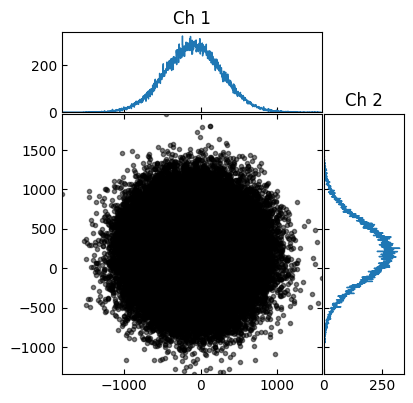

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.765781 sec
Captured 34 buffers (2.889736 buffers per sec)
Captured 104448 records (8877.268807 records per sec)
Transferred 1711276032 bytes (145445172.130877 bytes per sec)


<Figure size 800x800 with 0 Axes>

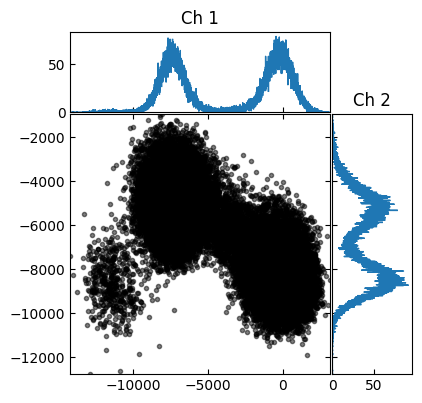

<Figure size 800x800 with 0 Axes>

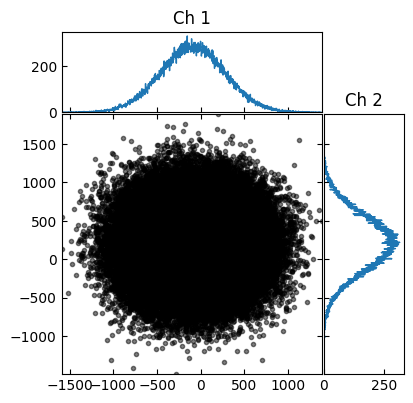

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.974335 sec
Captured 34 buffers (2.839406 buffers per sec)
Captured 104448 records (8722.655612 records per sec)
Transferred 1711276032 bytes (142911989.551006 bytes per sec)


<Figure size 800x800 with 0 Axes>

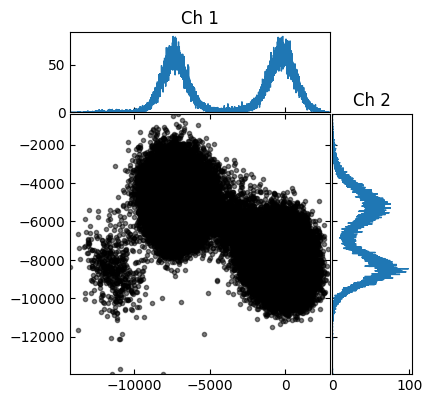

<Figure size 800x800 with 0 Axes>

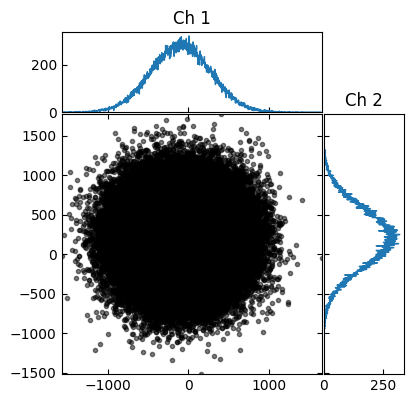

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.830620 sec
Captured 34 buffers (2.873898 buffers per sec)
Captured 104448 records (8828.616054 records per sec)
Transferred 1711276032 bytes (144648045.427217 bytes per sec)


<Figure size 800x800 with 0 Axes>

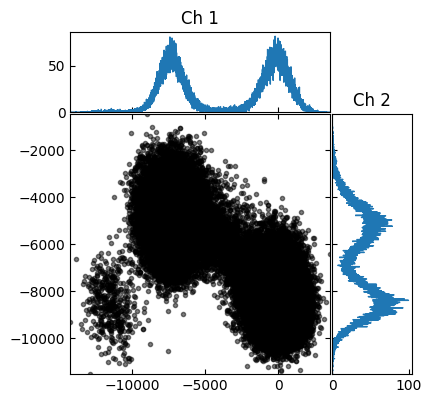

<Figure size 800x800 with 0 Axes>

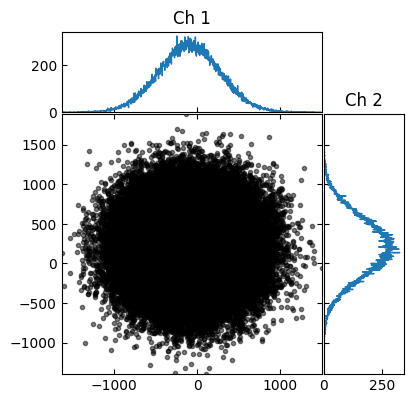

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.579816 sec
Captured 34 buffers (2.936143 buffers per sec)
Captured 104448 records (9019.832174 records per sec)
Transferred 1711276032 bytes (147780930.331498 bytes per sec)


<Figure size 800x800 with 0 Axes>

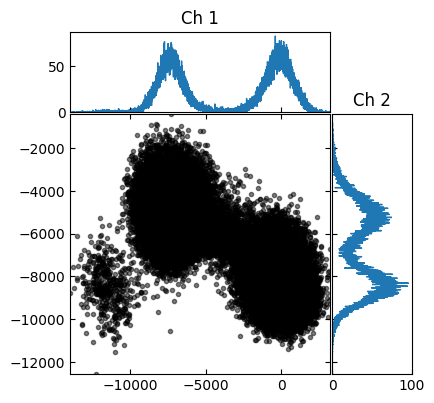

<Figure size 800x800 with 0 Axes>

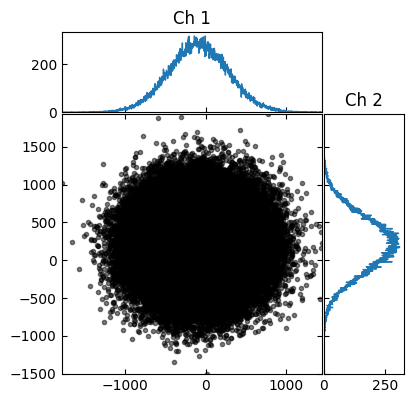

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.436541 sec
Captured 34 buffers (2.972927 buffers per sec)
Captured 104448 records (9132.831460 records per sec)
Transferred 1711276032 bytes (149632310.646504 bytes per sec)


<Figure size 800x800 with 0 Axes>

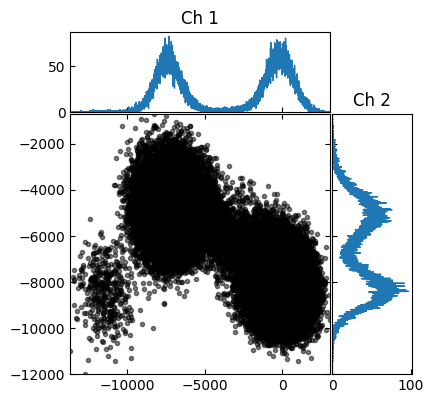

<Figure size 800x800 with 0 Axes>

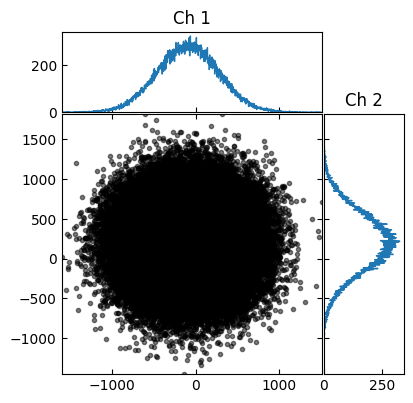

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 11.491943 sec
Captured 34 buffers (2.958595 buffers per sec)
Captured 104448 records (9088.802381 records per sec)
Transferred 1711276032 bytes (148910938.210211 bytes per sec)


<Figure size 800x800 with 0 Axes>

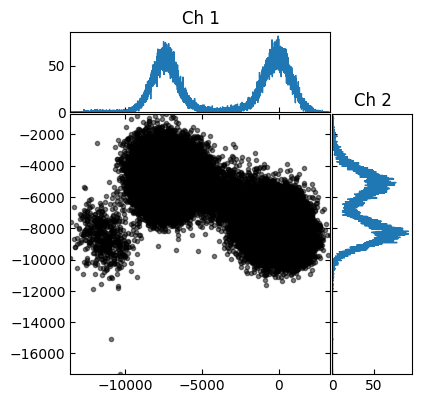

<Figure size 800x800 with 0 Axes>

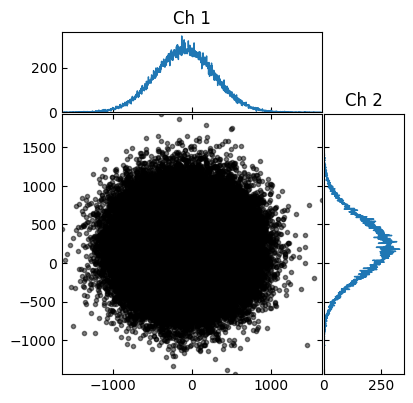

In [16]:
RO_ram_amp_start =0
RO_ram_amp_stop = .1
RO_ram_amp_steps = 21
RO_ram_ro_amp = np.linspace(RO_ram_amp_start, RO_ram_amp_stop,RO_ram_amp_steps)
ramsey_I, ramsey_Q = sweep_ramsey_quantum_efficiency(RO_ram_amp_start,RO_ram_amp_stop,RO_ram_amp_steps)

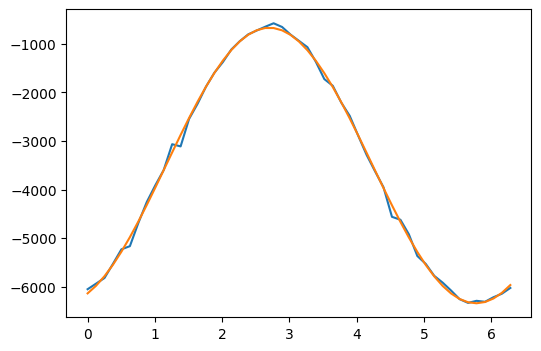



 amp: -2834.690212293819
phase: -73.4459458324138
offset: -3504.9842033067584
Index 0: Amp=-2834.69021 (I)


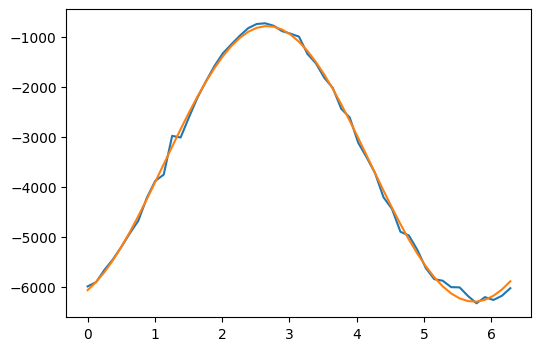



 amp: -2758.0430765689043
phase: -73.41536671247584
offset: -3538.2685721213024
Index 1: Amp=-2758.04308 (I)


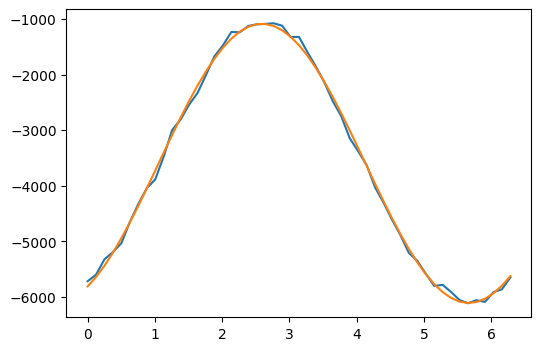



 amp: -2510.4754205940735
phase: -73.33544509583518
offset: -3595.6804492325273
Index 2: Amp=-2510.47542 (I)


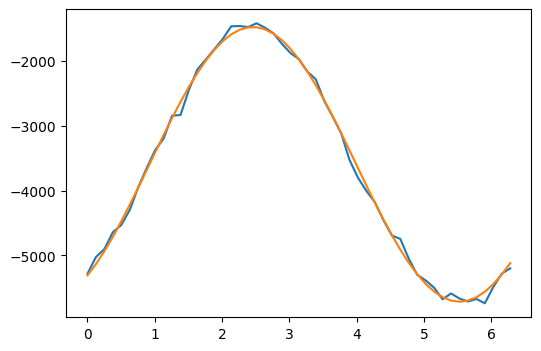



 amp: -2119.9774382563314
phase: -73.19736006287768
offset: -3593.5056409274716
Index 3: Amp=-2119.97744 (I)


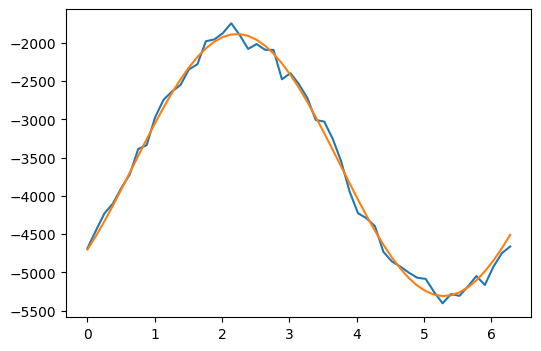



 amp: -1711.4480118300435
phase: -72.95749382385681
offset: -3597.152183353315
Index 4: Amp=-1711.44801 (I)


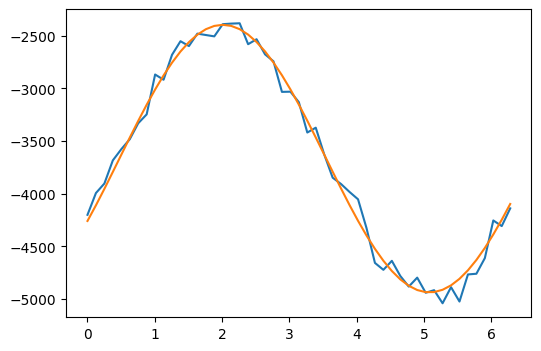



 amp: -1270.4171612673804
phase: -79.0247744500089
offset: -3665.722596625659
Index 5: Amp=-1270.41716 (I)


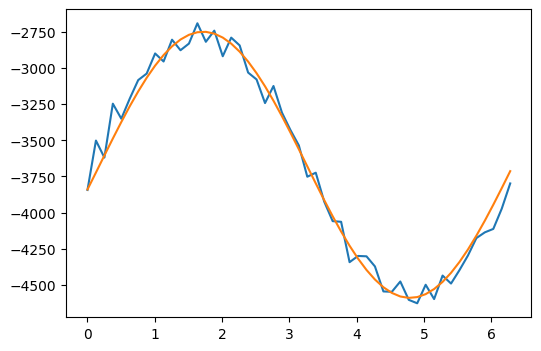



 amp: 919.980050372889
phase: -75.58474070482688
offset: -3669.5801089939155
Index 6: Amp=919.98005 (I)


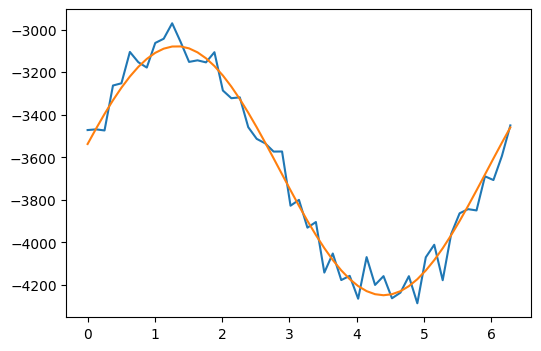



 amp: 584.9408271802422
phase: -68.89885004709876
offset: -3662.961822324972
Index 7: Amp=584.94083 (I)


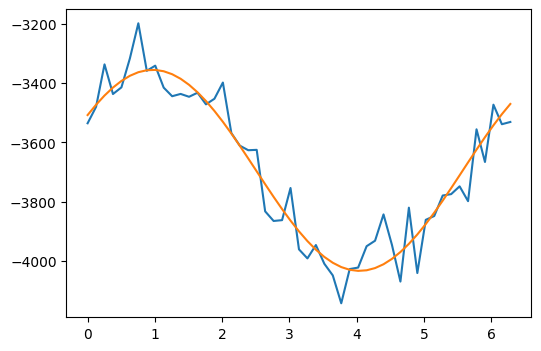



 amp: 338.9207804086219
phase: -68.5324574195244
offset: -3694.2856104943353
Index 8: Amp=338.92078 (I)


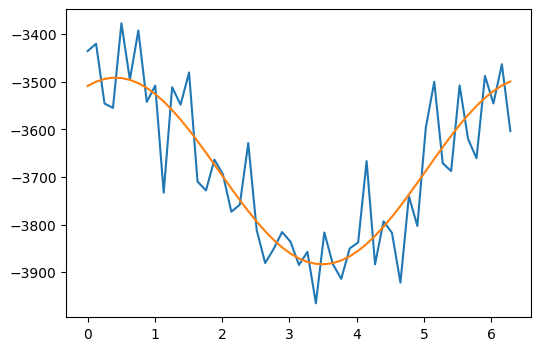



 amp: 196.01956060566113
phase: -67.96875117430847
offset: -3687.3655159540426
Index 9: Amp=196.01956 (I)


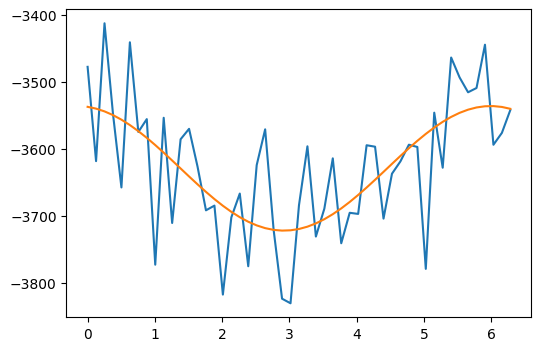



 amp: 92.83789368736018
phase: -67.38393613921731
offset: -3629.0033195395495
Index 10: Amp=92.83789 (I)


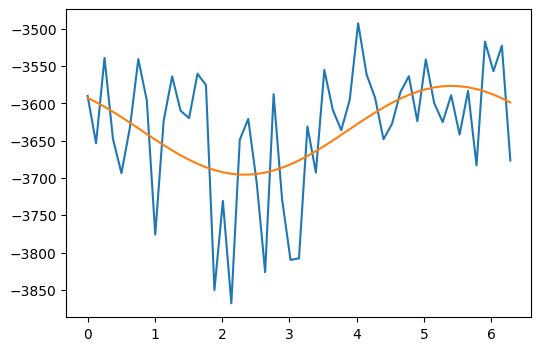



 amp: 59.57171574473187
phase: -66.7888997698598
offset: -3635.973458766657
Index 11: Amp=59.57172 (I)


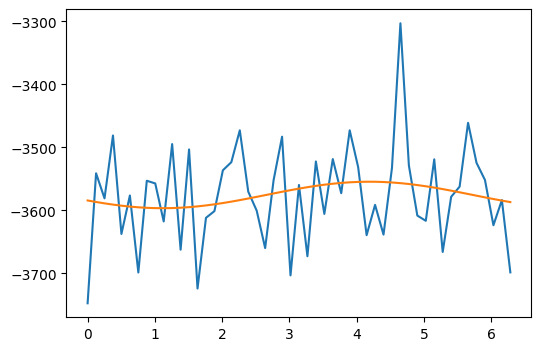



 amp: -21.012228210387484
phase: -68.68532188255891
offset: -3575.467821454209
Index 12: Amp=-21.01223 (I)


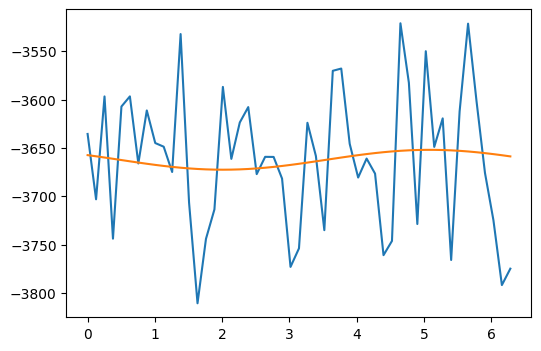



 amp: 10.277617274097022
phase: -66.4590581995088
offset: -3662.2454219682654
Index 13: Amp=10.27762 (I)


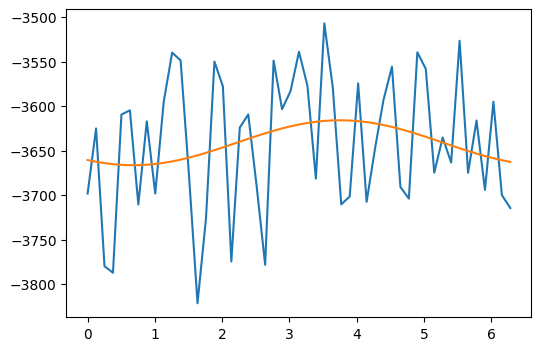



 amp: -25.24709359524847
phase: -68.23692028845987
offset: -3641.2414491674836
Index 14: Amp=-25.24709 (I)


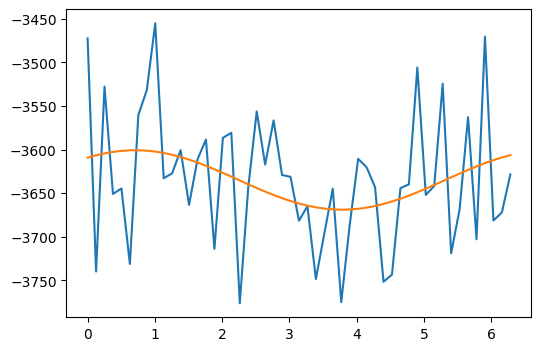



 amp: 34.1016554287031
phase: -68.26791309431421
offset: -3634.7922691853155
Index 15: Amp=34.10166 (I)


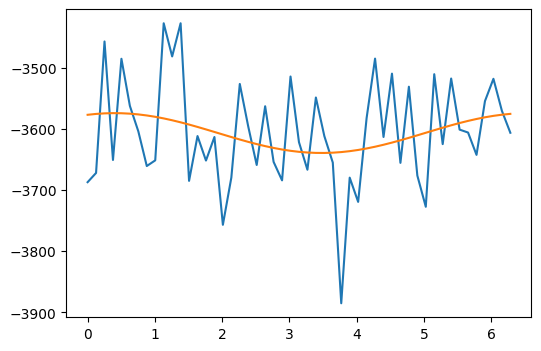



 amp: 32.53294497453807
phase: -67.95532023475332
offset: -3607.0522538334485
Index 16: Amp=32.53294 (I)


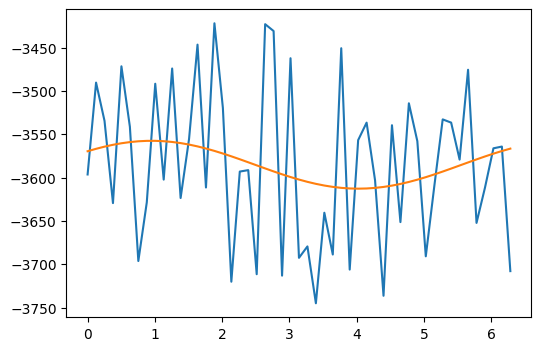



 amp: 27.618890110171925
phase: -68.51592378896628
offset: -3585.229416444466
Index 17: Amp=27.61889 (I)


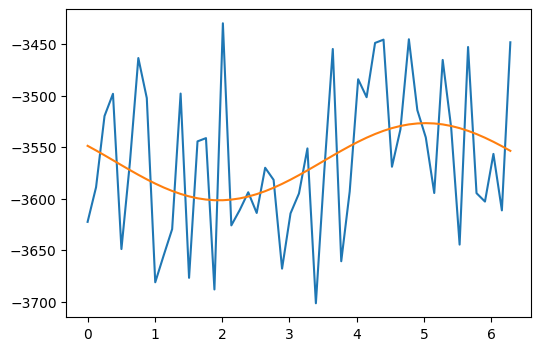



 amp: 37.429749104339585
phase: -66.3980115947064
offset: -3564.1579596205297
Index 18: Amp=37.42975 (I)


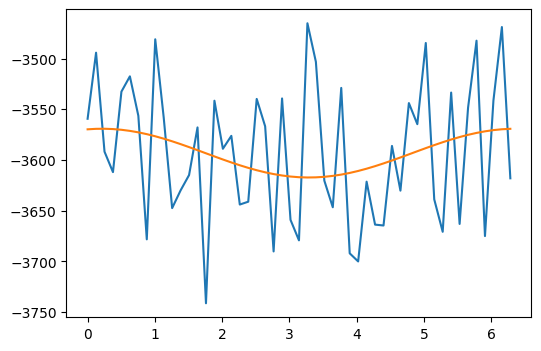



 amp: 24.049780758783385
phase: -67.7637423432262
offset: -3593.2778558958826
Index 19: Amp=24.04978 (I)


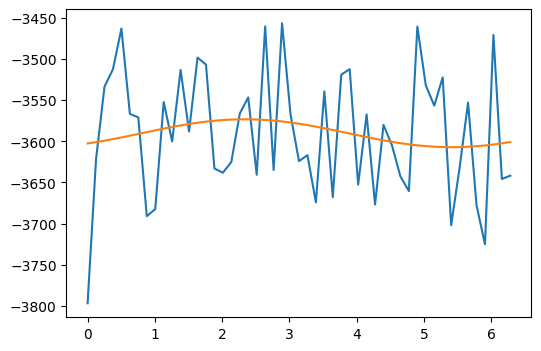



 amp: -16.94478327998154
phase: -66.79334133297212
offset: -3590.193578022719
Index 20: Amp=-16.94478 (I)


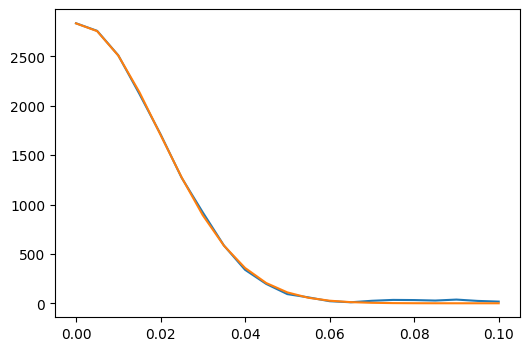



   amp: 138.35256265380315
 mu: 0.00037246178074973953
sigma: 0.01947375293688917


Text(0.5, 1.0, 'Ramsey Amplitude vs RO_ram_amp')

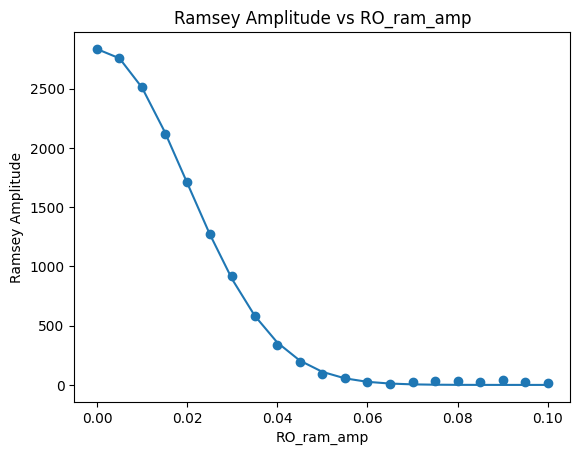

In [19]:
times = np.linspace(0, 2 * np.pi, num_steps)
fixed_freq=0.16267379625222506
ramsey_amp=fit_ramsey_amplitude(times, ramsey_I, ramsey_Q, fixed_freq) 
Gaussian_fit_vals,_,y_vals,_ = analysis.fit_gaussian_points(RO_ram_ro_amp,ramsey_amp,guess_vals=[300,0,1])
plt.scatter(RO_ram_ro_amp,ramsey_amp)
plt.plot(RO_ram_ro_amp, y_vals)
plt.xlabel("RO_ram_amp")
plt.ylabel("Ramsey Amplitude")
plt.title("Ramsey Amplitude vs RO_ram_amp")


In [20]:
0.5*(13.371855102575356**2)*(0.01947375293688917**2)

0.03390413275066334

In [8]:
# amp_start = 0
# amp_stop = 1
# amp_steps=21
# amp_list = np.linspace(amp_start, amp_stop, amp_steps)
# SNR_list = sweep_ro_amp(amp_list)
# plt.plot(amp_list, SNR_list)
# plt.xlabel("RO amp")
# plt.ylabel("SNR")
# plt.title("SNR vs RO amp")
# plt.show()
# freq_start = 6.6550
# freq_stop = 6.6560
# freq_steps=21
# freq_list = np.linspace(freq_start, freq_stop, freq_steps)
# SNR_list = sweep_ro_freq(freq_list)
# plt.plot(freq_list, SNR_list)
# plt.xlabel("RO Frequency (GHz)")
# plt.ylabel("SNR")
# plt.title("SNR vs RO Frequency")
# plt.show()

# num_steps=3
# reps=15000
# q2.ROIF = 6.65-readout_dict["RO_LO"]
# q2.ro_amp=0.5

# SNR= get_snr(q2, q1, general_vals_dict, num_steps, reps)

In [9]:
# max_idx = np.argmax(SNR_list)
# max_freq = amp_list[max_idx]
# max_snr = SNR_list[max_idx]

# print(f"Maximum SNR: {max_snr:.5f} at frequency: {max_freq:.6f} GHz")

In [10]:
# amp_list = np.array(amp_list)
# SNR_list = np.array(SNR_list)

# mask = amp_list < 0.7
# amp_fit = amp_list[mask]
# SNR_fit = SNR_list[mask]
# (popt, perr, y_vals_fit, pcov)=analysis.fit_line(amp_fit,SNR_fit)  
# plt.scatter(amp_fit, SNR_fit)  
# plt.plot(amp_fit, y_vals_fit, color='red', label='Fit line')
# plt.xlabel("RO amp")
# plt.ylabel("SNR")
# plt.title("SNR vs RO amp")
# plt.legend()